In [1]:
"""

Date: 12 Feb 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10

BCM-inspired sliding threshold implementation

"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# datasets
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 5000))
sampler_test = list(range(0, len(testset), 5000))
trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=4
lr=0.001
tlr=0.01 #threshold learning rate

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        #theta
        #self.threshold1 = nn.parameter.Parameter(torch.zeros((4, 12, 28, 28)), requires_grad=True)
        #mask
        #self.wconv = nn.parameter.Parameter(torch.empty(4, 12, 28, 28).normal_(mean=0.5,std=0.1), requires_grad=True)
        #self.wmax = nn.parameter.Parameter(torch.empty(4, 12, 28, 28).normal_(mean=0.5,std=0.1), requires_grad=True)
        #output target
        #self.ttarget = nn.parameter.Parameter(torch.ones((4, 12, 28, 28)), requires_grad=False)
        
        #theta
        self.threshold1 = torch.zeros((4, 12, 28, 28))
        #mask
        self.wconv = torch.empty(4, 12, 28, 28).normal_(mean=0.5,std=0.1)
        self.wmax = torch.empty(4, 12, 28, 28).normal_(mean=0.5,std=0.1)
        #output target
        self.ttarget = torch.ones((4, 12, 28, 28))
        
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
        self.memorized_1pixel = []
        self.thresh_max = []
        self.thresh_min = []
        self.thresh_mean = []
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.avg_pool2d(t, kernel_size=5, stride=1) # get avg result with the same kernel size
        t_2 = torch.cat((t_2, t_2, t_2, t_2), 1)
        t_conv = torch.mul(self.wconv,t_1)
        t_max = torch.mul(self.wmax,t_2)
        t = torch.add(t_conv, t_max) # compute the output
        self.threshold1 = self.threshold1 + tlr*(t**2/self.ttarget - self.threshold1) # update threshold
        self.wconv = self.wconv + lr*t_1*t*(t-self.threshold1) # update conv mask
        self.wmax = self.wmax + lr*t_2*t*(t-self.threshold1) # update max mask
        self.wconv[self.wconv < 0] = 0 # remove negative values
        self.wmax[self.wmax < 0] = 0 # remove negative values
        
        return t

max1 = net.flex1.memorized
conv1 = net.flex1.memorized
#input1 = torch.cat([max1, conv1], 0)
#print(input1.size())
mask = net.flex1.memorized
print(mask.size())
y = torch.mul(mask,max1)  # output of masked max
print(y.size())
t = mask*max1*(max1**2-mask)
print(t.size())

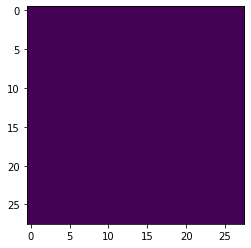

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=3, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 3 * 56 * 56, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 3 * 56 * 56)))
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()
memorized = net.flex1.memorized
#before training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [5]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

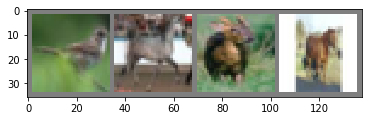

 bird horse  deer horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
#from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(comment=f'2_Bigdataset_test1-Optimisation-Xavier  batch_size={batch_size} lr={lr}')

<Figure size 432x288 with 0 Axes>

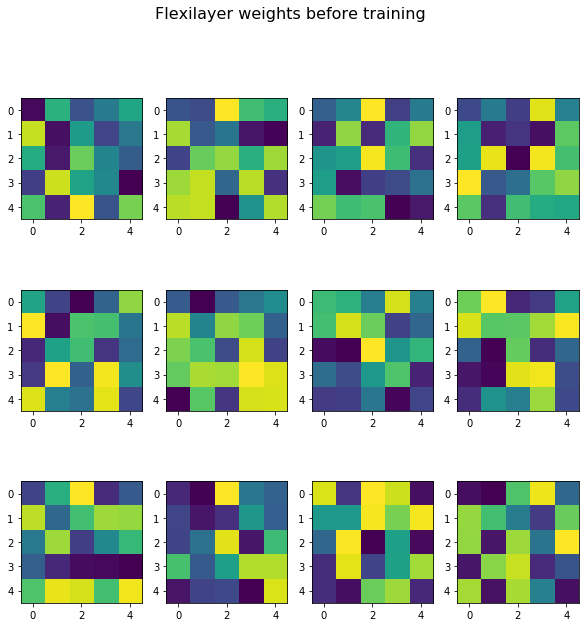

In [8]:
# plot the flex weights before training

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights before training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:]) # , cmap="gray"

    
fig.show()

In [9]:
running_loss = 0.0
total_loss_plt = []
for epoch in range(25):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
        
        net.flex1.memorized_1pixel.append(net.flex1.threshold1.detach().numpy()[1,1,10,10])
        net.flex1.thresh_max.append(torch.max(net.flex1.threshold1))
        net.flex1.thresh_min.append(torch.min(net.flex1.threshold1))
        net.flex1.thresh_mean.append(torch.mean(net.flex1.threshold1))
        
        if i % int(len(trainloader)/500) == 0:
            print("loss:", total_loss)
    
        if i == len(trainloader)-1:
            net.flex1.memorized_1loop = net.flex1.threshold1
            #at the end of every epoch plot threshold
            title = 'T'+str(epoch)
            plt.subplot(8,8, epoch + 1)
            plt.subplots_adjust(hspace=0.4, bottom=0.2)
            plt.title(title)
            #imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:])
            imgplot = plt.imshow(net.flex1.memorized_1loop.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])
            
    
    # ...log the total epoch accuracy
    # writer.add_scalar('Accuracy', total_correct / len(trainset), epoch)
       
    total_loss_plt.append(total_loss)
        
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

loss: 9.167072296142578
loss: 239.37840366363525
loss: 467.8548412322998
loss: 695.8694744110107
loss: 924.5694522857666
loss: 1153.2445230484009
loss: 1377.409420490265
loss: 1603.094509601593
loss: 1821.5396480560303


KeyboardInterrupt: 

In [ ]:
plt.plot(total_loss_plt)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [10]:
len(trainloader)

12500

In [ ]:
print('Accuracy is ', total_correct / len(trainset))

In [ ]:
#after training
plt.figure()
thresh_hist = torch.histc(net.flex1.wconv)
start = np.min(net.flex1.wconv.detach().numpy())
end = np.max(net.flex1.wconv.detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.detach().numpy())
plt.title('Conv mask histogram after training')
plt.xlabel('Count')
plt.xlabel('Conv mask values')

In [ ]:
#after training
plt.figure()
thresh_hist = torch.histc(net.flex1.wmax)
start = np.min(net.flex1.wmax.detach().numpy())
end = np.max(net.flex1.wmax.detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.detach().numpy())
plt.title('Max mask histogram after training')
plt.xlabel('Count')
plt.xlabel('Max mask values')

In [ ]:
#before training
plt.figure()
thresh_hist = torch.histc(memorized)
start = np.min(memorized.detach().numpy())
end = np.max(memorized.detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.detach().numpy())
plt.title('Threshold layer histogram before training')
plt.xlabel('Count')
plt.xlabel('Threshold layer values')

In [ ]:
#after training
plt.figure()
thresh_hist = torch.histc(net.flex1.threshold1)
start = np.min(net.flex1.threshold1.detach().numpy())
end = np.max(net.flex1.threshold1.detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.detach().numpy())
plt.title('Threshold layer histogram after training')
plt.xlabel('Count')
plt.xlabel('Threshold layer values')

In [ ]:
#after training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])
plt.colorbar()

In [ ]:
# plot the flex weights after training

fig = plt.figure()
fig = plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights after training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:]) # , cmap="gray"
#plt.colorbar()

    
fig.show()

In [ ]:
plt.plot(net.flex1.memorized_1pixel)
plt.ylabel('Single threshold layer pixel values')
plt.xlabel('Optimiser steps')
plt.show()

In [ ]:
plt.plot(net.flex1.thresh_mean)
plt.ylabel('Threshold layer mean value')
plt.xlabel('Optimiser steps')
plt.show()